# Group project: Mixture of regression - An application of the EM-algorithm 

by Buelent, Polina, Liva and Antonios

In [3]:
#Import relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
#sns.set_theme(style="darkgrid")
random.seed(10)
import math
import scipy.stats

# First part: Generating the synthetic data set 

In [4]:
bernoulli = random.random()
print(f'Random bernoulli variable is assigned as {bernoulli}')
x = np.random.uniform(0, 10, 1000)
label = np.random.binomial(1, bernoulli, 1000)
noise_a = np.random.normal(0, 1, 1000) 
noise_b = np.random.normal(0, 3, 1000)
d = {'x': x, 'label': label, 'noise_a': noise_a, 'noise_b': noise_b}
df = pd.DataFrame(data=d)
df.loc[df.label == 0, 'y'] = df.x * 3 + 2 + df.noise_a
df.loc[df.label == 1, 'y'] = df.x * 4 + 4 + df.noise_b
df

Random bernoulli variable is assigned as 0.5714025946899135


,x,label,noise_a,noise_b,y
0,8.025117,1,0.113399,3.617551,39.718020
1,2.492769,1,0.940146,-3.326751,10.644326
2,3.651194,1,1.029246,-4.668404,13.936371
3,1.891707,0,0.245683,5.249458,7.920805
4,3.954284,1,-0.435194,-6.186804,13.630331
...,...,...,...,...,...
995,4.618699,1,-1.714642,2.009513,24.484311
996,9.344789,0,-0.848112,-4.773929,29.186256
997,5.768826,0,0.253196,-2.487829,19.559674
998,2.374843,1,1.340462,-4.225697,9.273674


## Plotting the data for a first overview 

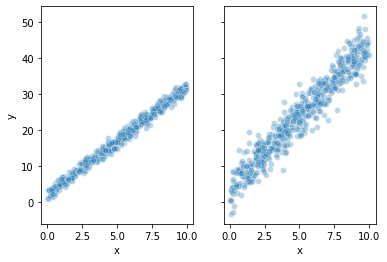

In [5]:
fig, ax =plt.subplots(1,2, sharey=True)
sns.scatterplot(data=df[df.label == 0],x='x', y='y', alpha=0.3,ax=ax[0])
sns.scatterplot(data=df[df.label == 1],x='x', y='y', alpha=0.3,ax=ax[1])


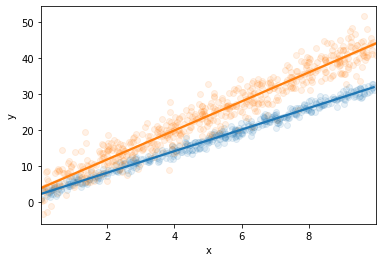

In [6]:
sns.regplot(data=df[df.label == 0],x='x', y='y',scatter_kws={'alpha':0.1})
sns.regplot(data=df[df.label == 1],x='x', y='y',scatter_kws={'alpha':0.1})


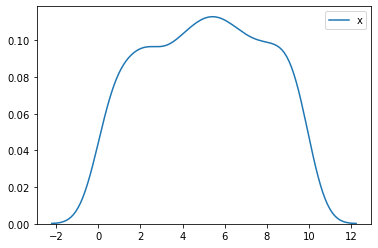

In [7]:
sns.kdeplot(data=df.x)

# Second part: Mathematical background 

# General Framework:

$$ y_i|x_i,z_i = j;\Theta \sim \mathcal{N}(\beta_{0j} + \beta_{1j} x_i,\sigma^{2}_{zi}) $$ 

$$ j \in \{1,2\} $$

$$ p(z_i = j) = \pi_j = 0.5 $$

$$ \Theta = (\beta_{01}, \beta_{11}, \beta_{02}, \beta_{12}, \sigma^{2}_{1},\sigma^{2}_{2}, \pi_1, \pi_2) $$

The EM algorithm is specified as follows:

$$ Q(\theta, \theta_0) = E_{p(\mathbf{z}|\mathbf{y},\mathbf{x},\theta_0)} [\log (p(\mathbf{y},\mathbf{z},\mathbf{x};\theta))] $$

In a first step, we define $w^i_j$ as follows:

$$ p(z_i = j|y_i,x_i;\theta_0) = \frac{p(z_i = j,y_i,x_i;\theta_0)}{p(y_i,x_i;\theta_0)} $$

where the numerator is given by (using Bayes' Theorem for the last expression):

$$ p(z_i =j,y_i,x_i;\theta_0) = p(y_i,x_i|z_i = j;\theta_0) p(z_i = j)  \propto p(y_i|x_i, zi_=j;\theta_0) p(z_i =j)$$

the denumerator is given by:

$$ p(y_i,x_i;\theta_0) = p(z_i = 1) p(y_i,x_i|z_i=1;\theta_0) + p(z_i = 2) p(y_i,x_i|z_i = 2;\theta_0)  $$

where again using Bayes' Thereom:

$$ p(z_i = 1) p(y_i,x_i|z_i=1;\theta_0) \propto p(z_i = 1) p(y_i|x_i,z_i=1;\theta_0) $$  

and 

$$ p(z_i = 2) p(y_i,x_i|z_i=2;\theta_0) \propto p(z_i = 2) p(y_i|x_i,z_i=2;\theta_0) $$

hold.

Now, in the expecation step, as we have a discrete latent variable, we calculate $w_1$ and $w_2$. After that, we have in the maximization step the following objective function that needs to be maximized:

$$ L(\theta) = \sum^N_{i=1} \sum^2_{j=1} w^i_j  [\log (p(z_i=j)) + log (p(y_i|x_i,z_i = j;\theta)] $$

where we know given the framework 

$$ p(y_i|z_i = j,x_i,\Theta) = \frac{1}{\sqrt{2\pi\sigma^{2}_{z_i}}} exp \{ -\frac{1}{2 \sigma^2_{z_i}}(y_i-\beta_{0j} + \beta_{1j})^2\}$$

also holds.

In order to get the updating rules that are used in the maximization step, we need to take the first derivative with respect to all parameters. In our case there are closed form solutions (which is not always the case!). We arrive to the following updating rules that will be used in the algorithm below:

$$ \beta_{0j} = \frac {\sum^N_{i=1} w^i_j (y_i -\beta_{1j}x_i)}{\sum^N_{i=1} w^i_j} $$

$$ \beta_{1j} = \frac {\sum^N_{i=1} w^i_j x_i (y_i -\beta_{0j})}{\sum^N_{i=1} x_i^2 w^i_j} $$

$$ \sigma_{z_i = j} = \frac {\sum^N_{i=1} w^i_j (y_i -\beta_{0j}-\beta_{1j}x_i)}{\sum^N_{i=1} w^i_j}  $$

$$ \pi_j = \frac {\sum^N_{i=1} w^i_j}{\sum^2_{j=1} \sum^N_{i=1} w^i_j} $$ 



# Third part: Implementation of the EM algorithm 

## Initialization of the parameter list

In [8]:
def initialize_parameter_list(d):
    d['variance_a']=random.randint(1, 3)
    d['variance_b']=random.randint(1, 3)
    d['beta_a0'] = random.uniform(0,5)
    d['beta_a1'] = random.uniform(0,5)
    d['beta_b0'] = random.uniform(0,5)
    d['beta_b1'] = random.uniform(0,5)
    d['prob_a'] = random.random()
    d['prob_b'] = 1 - d['prob_a']
    return d

In [9]:
# initialization of the parameter
params = initialize_parameter_list({})
params

{'variance_a': 2,
 'variance_b': 2,
 'beta_a0': 2.890456505672352,
 'beta_a1': 1.0304911606975087,
 'beta_b0': 4.0666062567866,
 'beta_b1': 4.117944362667227,
 'prob_a': 0.6534725339011758,
 'prob_b': 0.34652746609882423}

## Expectation step

In [10]:
##Expectation step
def Estep(p):
   
    #Set the values for the algorithm
    w_a_numerator  = p['prob_a'] * (1/np.sqrt(2*np.pi*p['variance_a'])) * np.exp((-(1/(2*p['variance_a'])) * (df.y - p['beta_a0'] - p['beta_a1']*df.x)**2))
    w_b_numerator  = p['prob_b'] * (1/np.sqrt(2*np.pi*p['variance_b'])) * np.exp((-(1/(2*p['variance_b'])) * (df.y - p['beta_b0'] - p['beta_b1']*df.x)**2))
    p['w_sum'] = w_a_numerator + w_b_numerator
    p['w_a'] = w_a_numerator/p['w_sum']
    p['w_b'] = w_b_numerator/p['w_sum']
    
    return p


## Maximisation step

In [11]:
## Maximisation step:
def Mstep(p, df):

    #Update the function following the derived update rules:
    
    #Update the prior beliefs
    p['prob_a'] = p['w_a'].sum()/(p['w_a'].sum() +p['w_b'].sum()).sum()
    p['prob_b'] = p['w_b'].sum()/(p['w_a'].sum() +p['w_b'].sum()).sum()
    
    #Update the betas for each subgroup
    #Beta_0
    
    p['beta_a0'] = ((df.y - p['beta_a1']*df.x)*p['w_a']).sum()/p['w_a'].sum() 
    p['beta_b0'] = ((df.y - p['beta_b1']*df.x)*p['w_b']).sum()/p['w_b'].sum() 
  
    #New beta formula
    p['beta_a1'] = ((df.y*df.x - p['beta_a0']*df.x)*p['w_a']).sum()/(p['w_a']*df.x**2).sum() 
    p['beta_b1'] = ((df.y*df.x - p['beta_b0']*df.x)*p['w_b']).sum()/(p['w_b']*df.x**2).sum() 
    #print('beta1', beta_a1, beta_b1)
    
    #Update the variance 
    #Define the residuals first
    e_hat_a = df.y - p['beta_a0']-p['beta_a1']*df.x
    e_hat_b = df.y - p['beta_b0']-p['beta_b1']*df.x
    #print('ehat', e_hat_a, e_hat_b)
    
    #Define the variance 

    p['variance_a'] = ((e_hat_a**2)*p['w_a']).sum()/p['w_a'].sum()
    p['variance_b'] = ((e_hat_b**2)*p['w_b']).sum()/p['w_b'].sum()

    return p
    

In [12]:
Mstep(Estep(params),df)


{'variance_a': 7.2083156436978255,
 'variance_b': 23.752953048710445,
 'beta_a0': 6.014247550587295,
 'beta_a1': 1.6904693683581482,
 'beta_b0': 0.6493098140328104,
 'beta_b1': 3.9839501356690725,
 'prob_a': 0.18967636420323108,
 'prob_b': 0.8103236357967689,
 'w_sum': 0      1.793385e-02
 1      3.487207e-03
 2      1.241898e-04
 3      1.921320e-02
 4      3.993186e-06
            ...     
 995    5.996368e-02
 996    4.036605e-21
 997    3.781753e-09
 998    4.358775e-03
 999    9.764138e-02
 Length: 1000, dtype: float64,
 'w_a': 0      2.919180e-88
 1      6.369749e-02
 2      2.581936e-03
 3      8.941438e-01
 4      6.937328e-01
            ...     
 995    5.230783e-31
 996    3.179817e-11
 997    1.586210e-05
 998    8.795425e-01
 999    3.164927e-64
 Length: 1000, dtype: float64,
 'w_b': 0      1.000000
 1      0.936303
 2      0.997418
 3      0.105856
 4      0.306267
          ...   
 995    1.000000
 996    1.000000
 997    0.999984
 998    0.120457
 999    1.000000
 Lengt

## Defining the average likelihood function

In [13]:
def get_avg_log_likelihood(p,df):
    
    Q_function_a = -1/2*((p['w_a']*((df.y-p['beta_a0']-p['beta_a1']*df.x)**2-math.log(p['variance_a']))).sum())
    Q_function_b = -1/2*((p['w_b']*((df.y-p['beta_b0']-p['beta_b1']*df.x)**2-math.log(p['variance_b']))).sum())
    
    Q_function = Q_function_a + Q_function_b
    
    return Q_function

## Running the EM-algorithm 

In [14]:
def run_em(p,df):
    avg_loglikelihoods = []
    p = initialize_parameter_list(p) #initialize params
    
    while True: 
        p = Mstep(Estep(p),df) # EM step
                
        #Evaluate the loglikelihood function
        avg_loglikelihood = get_avg_log_likelihood(p,df)
        avg_loglikelihoods.append(avg_loglikelihood)
        slope = 1/avg_loglikelihood
        if len(avg_loglikelihoods)>2 and (avg_loglikelihoods[-1] - avg_loglikelihoods[-2]) < 0:
            break
        if len(avg_loglikelihoods) > 2 and abs(avg_loglikelihoods[-1] - avg_loglikelihoods[-2]) < 0.0001: #Define a stopping criterion
            break
    
    return p, avg_loglikelihoods


In [15]:
new_params, log_likelies = run_em(params, df)

In [16]:
log_likelies[:10]

[-5143.5842187590815,
 -3688.738539068502,
 -3229.6738797862868,
 -3035.59213065692,
 -2926.572608554539,
 -2855.5927643419027,
 -2807.4770763170714,
 -2774.921948545113,
 -2750.6389290971965,
 -2727.6303023704522]

In [22]:
print('beta_a0 :'+str(new_params['beta_a0']), 'beta_a1 :'+str(new_params['beta_a1']))
print('beta_b0 :'+str(new_params['beta_b0']), 'beta_b1 :'+str(new_params['beta_b1']))
print('prob_class_1 :'+str(new_params['prob_b']), 'prob_class_0 :'+str(new_params['prob_a']))
print('variance_model_1 :'+str(new_params['variance_b']), 'variance_model_2 :'+str(new_params['variance_b']))

beta_a0 :2.140016483683324 beta_a1 :2.997360913874103
beta_b0 :3.911867172305733 beta_b1 :4.027005819837619
prob_class_1 :0.5498825868407252 prob_class_0 :0.45011741315927467
variance_model_1 :8.746637743279205 variance_model_2 :8.746637743279205


**Comments**: The EM algorithm worked well as the estimated values are very close to the true values. Also the estimated probabilities for the classes are almost identical to the one the data was generated with. Only the variance seems to be off and higher than for the true data generating process.

## Plotting the iterations 

In [15]:
iterations = np.arange(0,len(log_likelies),1)
data_log = pd.DataFrame(data={'logs': log_likelies, 'iterations': iterations})

In [16]:
data_log

,logs,iterations
0,-4906.895191,0
1,-3558.318392,1
2,-3126.588306,2
3,-2969.780027,3
4,-2897.810030,4
...,...,...
95,-2181.246425,95
96,-2181.246282,96
97,-2181.246161,97
98,-2181.246060,98


<AxesSubplot:xlabel='iterations', ylabel='logs'>

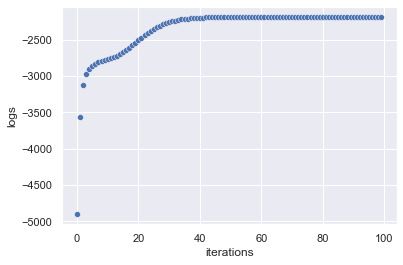

In [17]:
sns.scatterplot(x = 'iterations', y = 'logs', data = data_log)

**Comments**: We can see that the algorithm already converges after approximately 40 iterations. After that, there are only slight improvements in terms of the log likelihood. The relatively high number of iteration steps can be most likely be explained by the fact that in our updating rule in the algorithm (for $\alpha$ and $\beta$) are dependent on each other, i.e. for updating $\beta_0$ one needs to know $\beta_1$. As we take in our algorithm the previous value of $\beta_1$ instead of the already updated current value for $\beta_1$, the algorithm converges less fast.

# Numerical analysis

The EM algorithm is an algorithm that finds a local maximum. Yet, as the solution we end up with depends on the starting values, it is recommended to run the algorithm many times, i.e. do numerical simulation with varying initialized values. On this way, we can get valuable information on the parameters to be estimated.

In [ ]:
betas_a0 = []
betas_a1 = []
betas_b0 = []
betas_b1 = []
iterations = []
i = 0

for i in range(0,1000):
    parameter_list = initialize_parameter_list({})
    try:
        new_params, log_likelies = run_em(parameter_list, df)
    except:
        "math error"
    betas_a0.append(new_params['beta_a0'])
    betas_a1.append(new_params['beta_b0'])
    betas_b0.append(new_params['beta_a1'])
    betas_b1.append(new_params['beta_b1'])
    i+= 1
    iterations.append(i)

Text(0.5, 1.0, 'Beta B1')

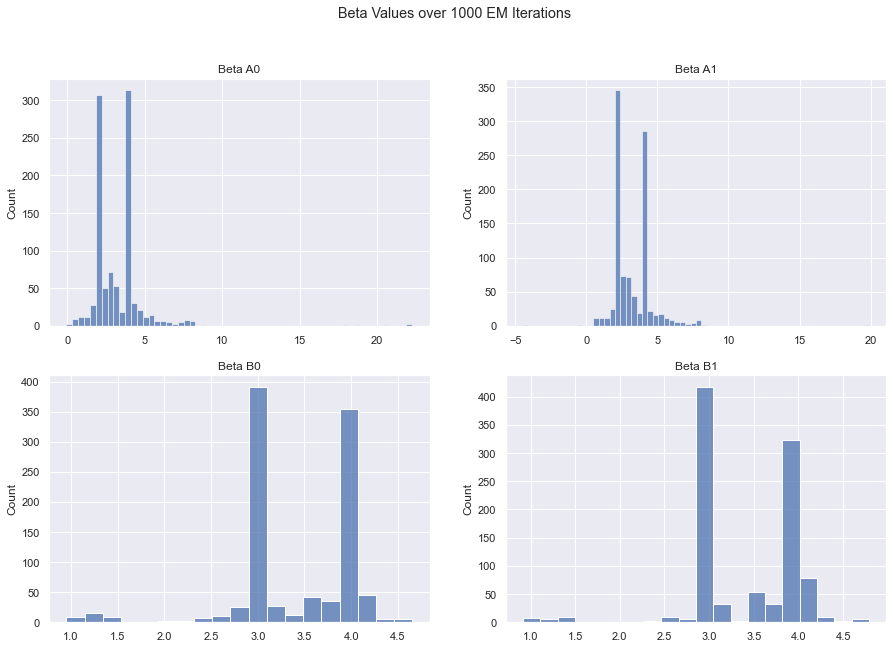

In [50]:
# sns.scatterplot(x = betas_a0, y = iterations)
fig, axes = plt.subplots(2, 2, figsize=(15,10))
fig.suptitle(f'Beta Values over {i} EM Iterations')
sns.histplot(x=betas_a0, ax=axes[0, 0]).set_title('Beta A0')
sns.histplot(x=betas_a1, ax=axes[0, 1]).set_title('Beta A1')
sns.histplot(x=betas_b0, ax=axes[1, 0]).set_title('Beta B0')
sns.histplot(x=betas_b1, ax=axes[1, 1]).set_title('Beta B1')

**Comments:** As we can see, for each parameter it seems as if there are two possible values. Yet, for all plots the true value is included. Yet, given the plots, it seems as if there are more than one local maxima, which underlines once more the need for numerical simulations.